In [1]:
import os
import importlib
import numpy as np
import tensorflow as tf

import texar.tf as tx
from texar.tf.modules import WordEmbedder, UnidirectionalRNNEncoder, \
        MLPTransformConnector, AttentionRNNDecoder, \
        GumbelSoftmaxEmbeddingHelper, Conv1DClassifier
from texar.tf.core import get_train_op
from texar.tf.utils import collect_trainable_variables, get_batch_size

from texar.tf.data import MultiAlignedData, FeedableDataIterator

from texar import HParams

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import copy

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import csv

import pickle
import re

/home/jupyter/v1/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Importing from `texar` is deprecated. Please import from `texar.tf` instead, e.g. `import texar.tf as tx`
  from ipykernel import kernelapp as app


In [2]:
config = {
    'max_nepochs': 12, # Total number of training epochs
                 # (including pre-train and full-train)
    'pretrain_ae_nepochs': 10, # Number of pre-train epochs (training as autoencoder)
    'display': 500,  # Display the training results every N training steps.
    'display_eval': 1e10, # Display the dev results every N training steps (set to a
                    # very large value to disable it).
    'sample_path': './samples_shiftedae',
    'checkpoint_path': './checkpoints_shiftedae',
    'restore': '',   # Model snapshot to restore from

    'lambda_g': 0.1,    # Weight of the classification loss
    'lambda_z1': 3000.,
    'lambda_z2': 3000.,
    'gamma_decay': 0.5,   # Gumbel-softmax temperature anneal rate

    'change_lambda_ae': 0.,
    'change_lambda_ae_epoch': 12,

    'plot_z': True,
    'plot_max_count': 1000,

    'spam': True,
    'repetitions': True,

    'write_text': True,
    'write_labels': True,

    'manual': True,

    # Data
    'train_data': {
        'batch_size': 64,
        'datasets': [
            {
                'files': './data/yelp/sentiment.train.text',
                'vocab_file': './data/yelp/vocab',
                'data_name': ''
            },
            {
                'files': './data/yelp/sentiment.train.labels',
                'data_type': 'int',
                'data_name': 'labels'
            }
        ],
        'name': 'train'
    }
}

config['val_data'] = copy.deepcopy(config['train_data'])
config['val_data']['datasets'][0]['files'] = './data/yelp/sentiment.dev.text'
config['val_data']['datasets'][1]['files'] = './data/yelp/sentiment.dev.labels'

config['test_data'] = copy.deepcopy(config['train_data'])
config['test_data']['datasets'][0]['files'] = './data/yelp/sentiment.test.text'
config['test_data']['datasets'][1]['files'] = './data/yelp/sentiment.test.labels'

if config['manual']:
    config['manual_data'] = copy.deepcopy(config['train_data'])
    config['manual_data']['datasets'][0]['files'] = './data/yelp/sentiment.manual.text'
    config['manual_data']['datasets'][1]['files'] = './data/yelp/sentiment.manual.labels'

model_dict = {
    'dim_c': 200,
    'dim_z': 500,
    'num_classes': 2,
    'embedder': {
        'dim': 100,
    },
    'encoder': {
        'rnn_cell': {
            'type': 'GRUCell',
            'kwargs': {
                'num_units': 700
            },
            'dropout': {
                'input_keep_prob': 0.5
            }
        }
    },
    'decoder': {
        'rnn_cell': {
            'type': 'GRUCell',
            'kwargs': {
                'num_units': 700,
            },
            'dropout': {
                'input_keep_prob': 0.5,
                'output_keep_prob': 0.5
            },
        },
        'attention': {
            'type': 'BahdanauAttention',
            'kwargs': {
                'num_units': 700,
            },
            'attention_layer_size': 700,
        },
        'max_decoding_length_train': 21,
        'max_decoding_length_infer': 20,
    },
    'classifier': {
        'kernel_size': [3, 4, 5],
        'filters': 128,
        'other_conv_kwargs': {'padding': 'same'},
        'dropout_conv': [1],
        'dropout_rate': 0.5,
        'num_dense_layers': 0,
        'num_classes': 1
    },
    'opt': {
        'optimizer': {
            'type':  'AdamOptimizer',
            'kwargs': {
                'learning_rate': 5e-4,
            },
        },
    }
}

In [3]:
class CtrlGenModel(object):

    def __init__(self, inputs, vocab, gamma, lambda_g, lambda_z1, lambda_z2, lambda_ae, hparams=None):
        self._hparams = tx.HParams(hparams, None)
        self._build_model(inputs, vocab, gamma, lambda_g, lambda_z1, lambda_z2, lambda_ae)


    def _build_model(self, inputs, vocab, gamma, lambda_g, lambda_z1, lambda_z2, lambda_ae):

        embedder = WordEmbedder(
            vocab_size=vocab.size,
            hparams=self._hparams.embedder)

        encoder = UnidirectionalRNNEncoder(hparams=self._hparams.encoder)

        enc_text_ids = inputs['text_ids'][:, 1:]
        enc_outputs, final_state = encoder(embedder(enc_text_ids),
                                           sequence_length=inputs['length']-1)

        z = final_state[:, self._hparams.dim_c:]

        label_connector = MLPTransformConnector(self._hparams.dim_c)

        labels = tf.to_float(tf.reshape(inputs['labels'], [-1, 1]))

        c = label_connector(labels)
        c_ = label_connector(1 - labels)

        h = tf.concat([c, z], 1)
        h_ = tf.concat([c_, z], 1)

        # Teacher-force decoding and the auto-encoding loss for G

        decoder = AttentionRNNDecoder(
            memory=enc_outputs,
            memory_sequence_length=inputs['length']-1,
            cell_input_fn=lambda inputs, attention: inputs,
            vocab_size=vocab.size,
            hparams=self._hparams.decoder)

        connector = MLPTransformConnector(decoder.state_size)

        g_outputs, _, _ = decoder(
            initial_state=connector(h), inputs=inputs['text_ids'],
            embedding=embedder, sequence_length=inputs['length']-1)

        loss_g_ae = tx.losses.sequence_sparse_softmax_cross_entropy(
            labels=inputs['text_ids'][:, 1:],
            logits=g_outputs.logits,
            sequence_length=inputs['length']-1,
            average_across_timesteps=True,
            sum_over_timesteps=False)

        # Gumbel-softmax decoding, used in training

        start_tokens = tf.ones_like(inputs['labels']) * vocab.bos_token_id

        end_token = vocab.eos_token_id

        gumbel_helper = GumbelSoftmaxEmbeddingHelper(
            embedder.embedding, start_tokens, end_token, gamma)

        soft_outputs_, _, soft_length_, = decoder(
            helper=gumbel_helper, initial_state=connector(h_))

        soft_outputs, _, soft_length, = decoder(
            helper=gumbel_helper, initial_state=connector(h))


        # ---------------------------- SHIFTED LOSS -------------------------------------
        _, encoder_final_state_ = encoder(embedder(soft_ids=soft_outputs_.sample_id),
                                          sequence_length=inputs['length'] - 1)
        _, encoder_final_state = encoder(embedder(soft_ids=soft_outputs.sample_id),
                                         sequence_length=inputs['length'] - 1)
        new_z_ = encoder_final_state_[:, self._hparams.dim_c:]
        new_z = encoder_final_state[:, self._hparams.dim_c:]

        cos_distance_z_ = tf.abs(
            tf.losses.cosine_distance(tf.nn.l2_normalize(z, axis=1), tf.nn.l2_normalize(new_z_, axis=1), axis=1))
        cos_distance_z = tf.abs(
            tf.losses.cosine_distance(tf.nn.l2_normalize(z, axis=1), tf.nn.l2_normalize(new_z, axis=1), axis=1))
        # ----------------------------______________-------------------------------------


        # Greedy decoding, used in eval

        outputs_, _, length_ = decoder(
            decoding_strategy='infer_greedy', initial_state=connector(h_),
            embedding=embedder, start_tokens=start_tokens, end_token=end_token)

        # Creates classifier

        classifier = Conv1DClassifier(hparams=self._hparams.classifier)

        clas_embedder = WordEmbedder(vocab_size=vocab.size,
                                     hparams=self._hparams.embedder)

        # Classification loss for the classifier

        clas_logits, clas_preds = classifier(
            inputs=clas_embedder(ids=inputs['text_ids'][:, 1:]),
            sequence_length=inputs['length']-1)

        loss_d_clas = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.to_float(inputs['labels']), logits=clas_logits)

        loss_d_clas = tf.reduce_mean(loss_d_clas)

        accu_d = tx.evals.accuracy(labels=inputs['labels'], preds=clas_preds)

        # Classification loss for the generator, based on soft samples

        soft_logits, soft_preds = classifier(
            inputs=clas_embedder(soft_ids=soft_outputs_.sample_id),
            sequence_length=soft_length_)

        loss_g_clas = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.to_float(1-inputs['labels']), logits=soft_logits)

        loss_g_clas = tf.reduce_mean(loss_g_clas)

        # Accuracy on soft samples, for training progress monitoring

        accu_g = tx.evals.accuracy(labels=1-inputs['labels'], preds=soft_preds)

        # Accuracy on greedy-decoded samples, for training progress monitoring

        _, gdy_preds = classifier(
            inputs=clas_embedder(ids=outputs_.sample_id),
            sequence_length=length_)

        accu_g_gdy = tx.evals.accuracy(
            labels=1-inputs['labels'], preds=gdy_preds)

        # Aggregates losses

        loss_g = lambda_ae * loss_g_ae + \
                 lambda_g * loss_g_clas + \
                 lambda_z1 * cos_distance_z + cos_distance_z_ * lambda_z2
        loss_d = loss_d_clas

        # Creates optimizers

        g_vars = collect_trainable_variables(
            [embedder, encoder, label_connector, connector, decoder])
        d_vars = collect_trainable_variables([clas_embedder, classifier])

        train_op_g = get_train_op(
            loss_g, g_vars, hparams=self._hparams.opt)
        train_op_g_ae = get_train_op(
            loss_g_ae, g_vars, hparams=self._hparams.opt)
        train_op_d = get_train_op(
            loss_d, d_vars, hparams=self._hparams.opt)

        # Interface tensors
        self.losses = {
            "loss_g": loss_g,
            "loss_g_ae": loss_g_ae,
            "loss_g_clas": loss_g_clas,
            "loss_d": loss_d_clas,
            "loss_cos_": cos_distance_z_,
            "loss_cos": cos_distance_z
        }
        self.metrics = {
            "accu_d": accu_d,
            "accu_g": accu_g,
            "accu_g_gdy": accu_g_gdy
        }
        self.train_ops = {
            "train_op_g": train_op_g,
            "train_op_g_ae": train_op_g_ae,
            "train_op_d": train_op_d
        }
        self.samples = {
            "original": inputs['text_ids'][:, 1:],
            "transferred": outputs_.sample_id,
            "z_vector": z,
            "labels_source": inputs['labels'],
            "labels_target": 1 - inputs['labels'],
            "labels_predicted": gdy_preds
        }

        self.fetches_train_g = {
            "loss_g": self.train_ops["train_op_g"],
            "loss_g_ae": self.losses["loss_g_ae"],
            "loss_g_clas": self.losses["loss_g_clas"],
            "loss_shifted_ae1": self.losses["loss_cos"],
            "loss_shifted_ae2": self.losses["loss_cos_"],
            "accu_g": self.metrics["accu_g"],
            "accu_g_gdy": self.metrics["accu_g_gdy"]
        }

        self.fetches_train_d = {
            "loss_d": self.train_ops["train_op_d"],
            "accu_d": self.metrics["accu_d"]
        }
        fetches_eval = {"batch_size": get_batch_size(inputs['text_ids'])}
        fetches_eval.update(self.losses)
        fetches_eval.update(self.metrics)
        fetches_eval.update(self.samples)
        self.fetches_eval = fetches_eval

In [4]:
def train_model():
    # Data
    train_data = MultiAlignedData(config['train_data'])
    val_data = MultiAlignedData(config['val_data'])
    test_data = MultiAlignedData(config['test_data'])
    if config['manual']:
        manual_data = MultiAlignedData(config['manual_data'])
    vocab = train_data.vocab(0)

    # Each training batch is used twice: once for updating the generator and
    # once for updating the discriminator. Feedable data iterator is used for
    # such case.
    if config['manual']:
        iterator = tx.data.FeedableDataIterator(
            {'train_g': train_data, 'train_d': train_data,
             'val': val_data, 'test': test_data, 'manual': manual_data})
    else:
        iterator = tx.data.FeedableDataIterator(
            {'train_g': train_data, 'train_d': train_data,
             'val': val_data, 'test': test_data})
    batch = iterator.get_next()

    # Model
    gamma = tf.placeholder(dtype=tf.float32, shape=[], name='gamma')
    lambda_g = tf.placeholder(dtype=tf.float32, shape=[], name='lambda_g')
    lambda_z1 = tf.placeholder(dtype=tf.float32, shape=[], name='lambda_z1')
    lambda_z2 = tf.placeholder(dtype=tf.float32, shape=[], name='lambda_z2')
    lambda_ae = tf.placeholder(dtype=tf.float32, shape=[], name='lambda_ae')
    model = CtrlGenModel(batch, vocab, gamma, lambda_g, lambda_z1, lambda_z2, lambda_ae, model_dict)
    
    def _train_epoch(sess, gamma_, lambda_g_, lambda_z1_, lambda_z2_, lambda_ae_, epoch, verbose=True):
        avg_meters_d = tx.utils.AverageRecorder(size=10)
        avg_meters_g = tx.utils.AverageRecorder(size=10)

        step = 0
        while True:
            try:
                step += 1
                feed_dict = {
                    iterator.handle: iterator.get_handle(sess, 'train_d'),
                    gamma: gamma_,
                    lambda_g: lambda_g_,
                    lambda_z1: lambda_z1_,
                    lambda_z2: lambda_z2_,
                    lambda_ae: lambda_ae_
                }

                vals_d = sess.run(model.fetches_train_d, feed_dict=feed_dict)
                avg_meters_d.add(vals_d)

                feed_dict = {
                    iterator.handle: iterator.get_handle(sess, 'train_g'),
                    gamma: gamma_,
                    lambda_g: lambda_g_,
                    lambda_z1: lambda_z1_,
                    lambda_z2: lambda_z2_,
                    lambda_ae: lambda_ae_
                }
                vals_g = sess.run(model.fetches_train_g, feed_dict=feed_dict)
                avg_meters_g.add(vals_g)

                if verbose and (step == 1 or step % config['display'] == 0):
                    print('epoch: {}, step: {}, {}'.format(epoch, step, avg_meters_d.to_str(4)))
                    print('epoch: {}, step: {}, {}'.format(epoch, step, avg_meters_g.to_str(4)))

                if verbose and step % config['display_eval'] == 0:
                    iterator.restart_dataset(sess, 'val')
                    _eval_epoch(sess, gamma_, lambda_g_, lambda_z1_, lambda_z2_, lambda_ae_, epoch)

            except tf.errors.OutOfRangeError:
                print('epoch: {}, {}'.format(epoch, avg_meters_d.to_str(4)))
                print('epoch: {}, {}'.format(epoch, avg_meters_g.to_str(4)))
                break
    
    def _eval_epoch(sess, gamma_, lambda_g_, lambda_z1_,lambda_z2_, lambda_ae_, epoch, val_or_test='val',
                    plot_z=False, plot_max_count=1000, spam=False, repetitions=False, write_text=True,
                    write_labels=False):
        avg_meters = tx.utils.AverageRecorder()

        if plot_z:
            z_vectors = []
            labels = []
            tsne = TSNE(n_components=2)
        while True:
            try:
                feed_dict = {
                    iterator.handle: iterator.get_handle(sess, val_or_test),
                    gamma: gamma_,
                    lambda_g: lambda_g_,
                    lambda_z1: lambda_z1_,
                    lambda_z2: lambda_z2_,
                    lambda_ae: lambda_ae_,
                    tx.context.global_mode(): tf.estimator.ModeKeys.EVAL
                }

                vals = sess.run(model.fetches_eval, feed_dict=feed_dict)

                batch_size = vals.pop('batch_size')

                # Computes BLEU
                samples = tx.utils.dict_pop(vals, list(model.samples.keys()))
                hyps = tx.utils.map_ids_to_strs(samples['transferred'], vocab)

                refs = tx.utils.map_ids_to_strs(samples['original'], vocab)
                refs = np.expand_dims(refs, axis=1)

                bleu = tx.evals.corpus_bleu_moses(refs, hyps)
                vals['bleu'] = bleu

                if spam or repetitions:
                    target_labels = samples['labels_target']
                    predicted_labels = samples['labels_predicted']

                    results = [(r, h, t, p) for r, h, t, p in zip(refs, hyps, target_labels, predicted_labels)]

                # Computes repetitions
                if repetitions:
                    count_equal_strings = 0
                    remain_samples_e = []
                    for r, h, t, p in results:
                        if r == h:
                            count_equal_strings += 1
                        else:
                            remain_samples_e.append((r, h, t, p))
                    vals['equal'] = count_equal_strings / len(hyps)

                # Computes spam
                if spam:
                    count_spam = 0
                    remain_samples_s = []
                    for r, h, t, p in results:
                        words = h.split()
                        if len(words) > 2 and words[-1] == words[-2]:
                            count_spam += 1
                        elif len(words) > 4 and words[-1] == words[-3] and words[-2] == words[-4]:
                            count_spam += 1
                        else:
                            remain_samples_s.append((r, h, t, p))
                    vals['spam'] = count_spam / len(hyps)

                if repetitions and spam:
                    remain_samples = [sample for sample in remain_samples_e if sample in remain_samples_s]
                    remain_samples = list(remain_samples)
                elif not repetitions and spam:
                    remain_samples = remain_samples_s
                elif repetitions and not spam:
                    remain_samples = remain_samples_e

                if repetitions and spam:
                    refs_remain = [r for r, h, t, p in remain_samples]
                    hyps_remain = [h for r, h, t, p in remain_samples]
                    bleu_remain = tx.evals.corpus_bleu_moses(refs_remain, hyps_remain)
                    vals['bleu_remain'] = bleu_remain

                    if len(remain_samples) != 0:
                        true_labels = 0
                        for _, _, t, p in remain_samples:
                            if t == p:
                                true_labels += 1
                        vals['acc_remain'] = true_labels / len(remain_samples)
                    else:
                        vals['acc_remain'] = 0.

                avg_meters.add(vals, weight=batch_size)

                if plot_z:
                    z_vectors += samples['z_vector'].tolist()
                    labels += samples['labels_source'].tolist()

                # Writes samples
                if write_text:
                    tx.utils.write_paired_text(
                        refs.squeeze(), hyps,
                        os.path.join(config['sample_path'], 'text_{}.{}'.format(val_or_test, epoch)),
                        append=True, mode='v')

                # Writes labels samples
                if write_labels:
                    tx.utils.write_paired_text(
                        [str(l) for l in samples['labels_target'].tolist()],
                        [str(l) for l in samples['labels_predicted'].tolist()],
                        os.path.join(config['sample_path'], 'labels_{}.{}'.format(val_or_test, epoch)),
                        append=True, mode='v')

            except tf.errors.OutOfRangeError:
                print('epoch: {}, {}: {}'.format(
                    epoch, val_or_test, avg_meters.to_str(precision=4)))
                break

        if plot_z:
            if plot_max_count == 0:
                z_vectors = z_vectors
                labels = labels
            else:
                z_vectors = z_vectors[:plot_max_count]
                labels = labels[:plot_max_count]
            tsne_result = tsne.fit_transform(np.array(z_vectors))
            x_data = tsne_result[:, 0]
            y_data = tsne_result[:, 1]
            
            plt.rcParams["figure.figsize"] = 10, 10
            plt.scatter(x_data, y_data, c=np.array(labels), s=2, cmap=plt.cm.get_cmap('jet', 2))
            plt.clim(0.0, 1.0)
            if not os.path.exists('./images'):
                os.makedirs('./images')
            plt.savefig('./images/{}_{}.png'.format(val_or_test, epoch))
            plt.show()

        return avg_meters.avg()

    tf.gfile.MakeDirs(config['sample_path'])
    tf.gfile.MakeDirs(config['checkpoint_path'])

    # Runs the logics
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        sess.run(tf.tables_initializer())

        saver = tf.train.Saver(max_to_keep=None)
        if config['restore']:
            print('Restore from: {}'.format(config['restore']))
            saver.restore(sess, conig['restore'])

        iterator.initialize_dataset(sess)

        gamma_ = 1.
        lambda_g_ = 0.
        lambda_ae_ = 1.
        lambda_z1_ = config['lambda_z1']
        lambda_z2_ = config['lambda_z2']
        for epoch in range(1, config['max_nepochs']+1):
            if epoch > config['pretrain_ae_nepochs']:
                # Anneals the gumbel-softmax temperature
                gamma_ = max(0.001, gamma_ * config['gamma_decay'])
                lambda_g_ = config['lambda_g']
            if epoch > config['change_lambda_ae_epoch']:
                lambda_ae_ = lambda_ae_ - config['change_lambda_ae']
            print('gamma: {}, lambda_g: {}, lambda_z1: {}, lambda_z2: {}, lambda_ae: {}'.format(
                gamma_, lambda_g_, lambda_z1_, lambda_z2_, lambda_ae_))

            # Train
            iterator.restart_dataset(sess, ['train_g', 'train_d'])
            _train_epoch(sess, gamma_, lambda_g_, lambda_z1_, lambda_z2_, lambda_ae_, epoch)

            # Val
            iterator.restart_dataset(sess, 'val')
            _eval_epoch(sess, gamma_, lambda_g_, lambda_z1_, lambda_z2_, lambda_ae_, epoch, 'val', plot_z=config['plot_z'],
                        plot_max_count=config['plot_max_count'], spam=config['spam'], repetitions=config['repetitions'],
                        write_text=config['write_text'], write_labels=config['write_labels'])

            saver.save(
                sess, os.path.join(config['checkpoint_path'], 'ckpt'), epoch)

            # Test
            iterator.restart_dataset(sess, 'test')
            _eval_epoch(sess, gamma_, lambda_g_, lambda_z1_, lambda_z2_, lambda_ae_, epoch, 'test', plot_z=config['plot_z'],
                        plot_max_count=config['plot_max_count'], spam=config['spam'], repetitions=config['repetitions'],
                        write_text=config['write_text'], write_labels=config['write_labels'])

            if config['manual']:
                iterator.restart_dataset(sess, 'manual')
                _eval_epoch(sess, gamma_, lambda_g_, lambda_z1_, lambda_z2_, lambda_ae_, epoch, 'manual', plot_z=config['plot_z'],
                        plot_max_count=config['plot_max_count'], spam=config['spam'], repetitions=config['repetitions'],
                        write_text=config['write_text'], write_labels=config['write_labels'])

In [10]:
def print_result():
    TEXT_FILE = '{}/text_val.{}'.format(config['sample_path'], config['max_nepochs'])
    LABELS_FILE = '{}/labels_val.{}'.format(config['sample_path'], config['max_nepochs'])

    smoothing_function = SmoothingFunction()
    samples = []
    total_bleu = 0
    accuracy = 0
    samples.append(['Input Sentence', 'Input Label', 'Generated Sentence', 'Predicted Label', 'BLEU'])
    with open(TEXT_FILE, 'r') as input_file_text:
        lines_text = input_file_text.readlines()
        with open(LABELS_FILE, 'r') as input_file_labels:
            lines_labels = input_file_labels.readlines()
            for i in range(0, len(lines_text)-1, 2):
                input_sentence = lines_text[i].strip()
                generated_sentence = lines_text[i + 1].strip()
                input_label = 1 - int(lines_labels[i])
                predicted_label = int(lines_labels[i + 1])
                if input_label != predicted_label:
                    accuracy += 1

                words_input = input_sentence.split()
                words_generated = generated_sentence.split()
                try:
                    score = sentence_bleu([words_input], words_generated, smoothing_function=smoothing_function.method4)
                    total_bleu += score
                except Exception:
                    #print(input_sentence)
                    #print(generated_sentence)
                    pass

                samples.append([input_sentence, input_label, generated_sentence, predicted_label, score])
    with open('samples_shiftdae.csv', 'w', newline='') as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
        for line in samples:
            writer.writerow(line)
    print (samples[:100])
    print ('BLEU: {:.4}'.format(total_bleu / (len(samples)-1)))
    print ('accuracy: {:.4}'.format(accuracy / (len(samples)-1)))

In [11]:
def print_bleu():
    GENERATED_FILE = '{}/text_manual.{}'.format(config['sample_path'], config['max_nepochs'])
    SOURCE_TARGET_DICT_PATH = './data/yelp/dict.pkl'

    with open(SOURCE_TARGET_DICT_PATH, 'rb') as pkl_file:
        source_target_dict = pickle.load(pkl_file)

    samples = []
    with open(GENERATED_FILE, 'r') as input_file:
        lines = input_file.readlines()
        for i in range(0, len(lines), 2):
            source = lines[i].strip()
            generated = lines[i + 1].strip()

            source_clean = re.sub(r'<UNK> ', "", source)
            key = ''
            for target_str in source_target_dict.keys():
                word_count = 0
                for word1 in source_clean.split():
                    if word1 in target_str.split():
                        word_count += 1
                if word_count == len(source_clean.split()):
                    key = target_str
                    break

            target = source_target_dict[key]
            samples.append((source, target, generated))

    total_bleu = 0
    smoothing_function = SmoothingFunction()
    for _, t, g in samples:
        target_words = t.strip().split()
        generated_words = g.strip().split()
        score = sentence_bleu([target_words], generated_words, smoothing_function=smoothing_function.method4)
        total_bleu += score

    print('BLEU: {:.4}'.format(total_bleu / len(samples)))

gamma: 1.0, lambda_g: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 1, step: 1, loss_d: 0.6929 accu_d: 0.5312
epoch: 1, step: 1, loss_g: 5944.4121 loss_g_ae: 9.1434 loss_g_clas: 0.6955 loss_shifted_ae1: 0.9800 loss_shifted_ae2: 0.9985 accu_g: 0.3750 accu_g_gdy: 0.4531
epoch: 1, step: 500, loss_d: 0.1147 accu_d: 0.9563
epoch: 1, step: 500, loss_g: 6.0450 loss_g_ae: 4.7079 loss_g_clas: 0.6465 loss_shifted_ae1: 0.0002 loss_shifted_ae2: 0.0002 accu_g: 0.7000 accu_g_gdy: 0.9000
epoch: 1, step: 1000, loss_d: 0.0984 accu_d: 0.9703
epoch: 1, step: 1000, loss_g: 5.1772 loss_g_ae: 4.7301 loss_g_clas: 0.1669 loss_shifted_ae1: 0.0001 loss_shifted_ae2: 0.0001 accu_g: 0.9594 accu_g_gdy: 0.9859
epoch: 1, step: 1500, loss_d: 0.1174 accu_d: 0.9625
epoch: 1, step: 1500, loss_g: 4.8231 loss_g_ae: 4.6238 loss_g_clas: 0.1624 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.9688 accu_g_gdy: 0.9563
epoch: 1, step: 2000, loss_d: 0.0585 accu_d: 0.9844
epoch: 1, step: 2000, loss_g:

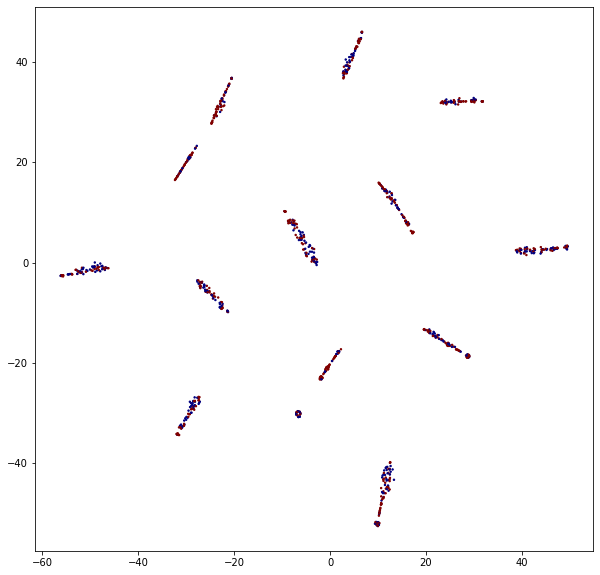

epoch: 1, test: loss_g: 3.3951 loss_g_ae: 3.3861 loss_g_clas: 0.1789 loss_d: 0.0713 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9746 accu_g: 0.9608 accu_g_gdy: 0.9651 bleu: 0.2493 equal: 0.0004 spam: 0.0532 bleu_remain: 0.2383 acc_remain: 0.9676


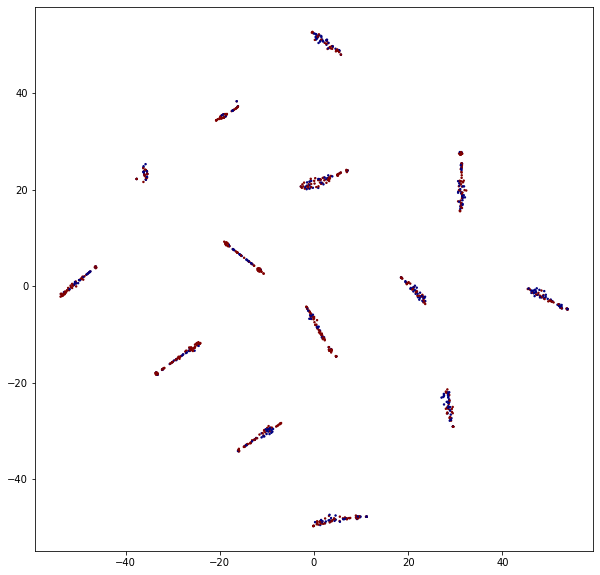

epoch: 1, manual: loss_g: 3.7090 loss_g_ae: 3.7052 loss_g_clas: 0.1790 loss_d: 0.0818 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9710 accu_g: 0.9610 accu_g_gdy: 0.9650 bleu: 0.4723 equal: 0.0000 spam: 0.0570 bleu_remain: 0.4736 acc_remain: 0.9683


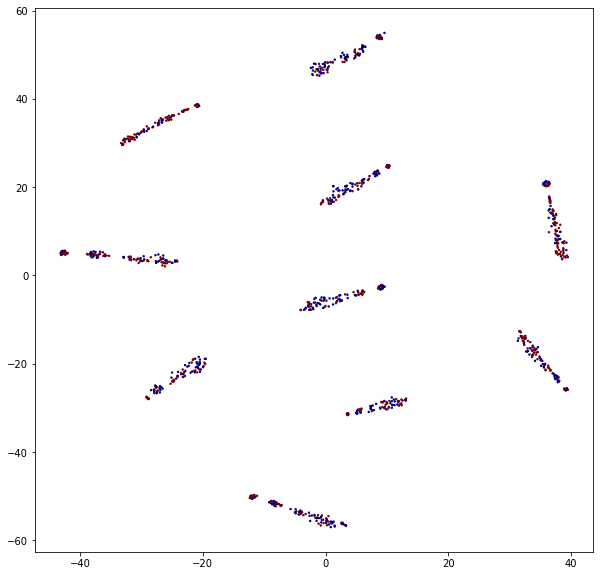

gamma: 1.0, lambda_g: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 2, step: 1, loss_d: 0.0647 accu_d: 0.9688
epoch: 2, step: 1, loss_g: 3.6169 loss_g_ae: 3.5963 loss_g_clas: 0.1783 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.9375 accu_g_gdy: 0.9062
epoch: 2, step: 500, loss_d: 0.0499 accu_d: 0.9781
epoch: 2, step: 500, loss_g: 3.3562 loss_g_ae: 3.3344 loss_g_clas: 0.1696 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.9594 accu_g_gdy: 0.9578
epoch: 2, step: 1000, loss_d: 0.0507 accu_d: 0.9781
epoch: 2, step: 1000, loss_g: 3.2445 loss_g_ae: 3.2271 loss_g_clas: 0.2488 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.9313 accu_g_gdy: 0.9234
epoch: 2, step: 1500, loss_d: 0.0476 accu_d: 0.9859
epoch: 2, step: 1500, loss_g: 3.0853 loss_g_ae: 3.0701 loss_g_clas: 0.2650 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.9297 accu_g_gdy: 0.9266
epoch: 2, step: 2000, loss_d: 0.0473 accu_d: 0.9781
epoch: 2, step: 2000, loss_g: 3.

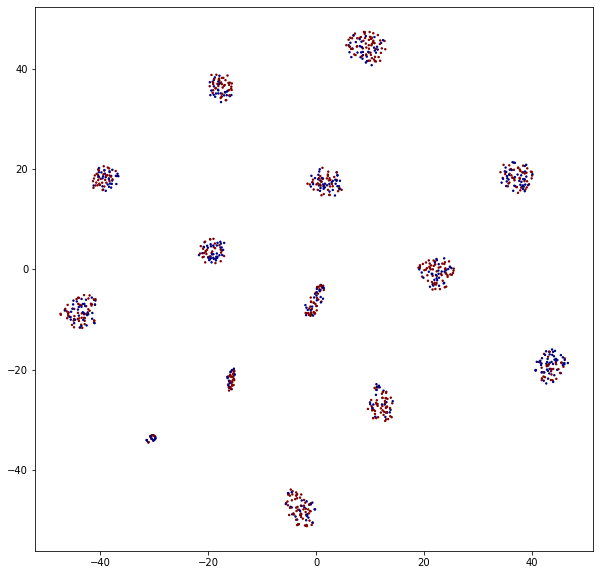

epoch: 2, test: loss_g: 0.8403 loss_g_ae: 0.8300 loss_g_clas: 3.4010 loss_d: 0.0674 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9765 accu_g: 0.3456 accu_g_gdy: 0.3444 bleu: 54.4713 equal: 0.2804 spam: 0.0023 bleu_remain: 45.5915 acc_remain: 0.4740


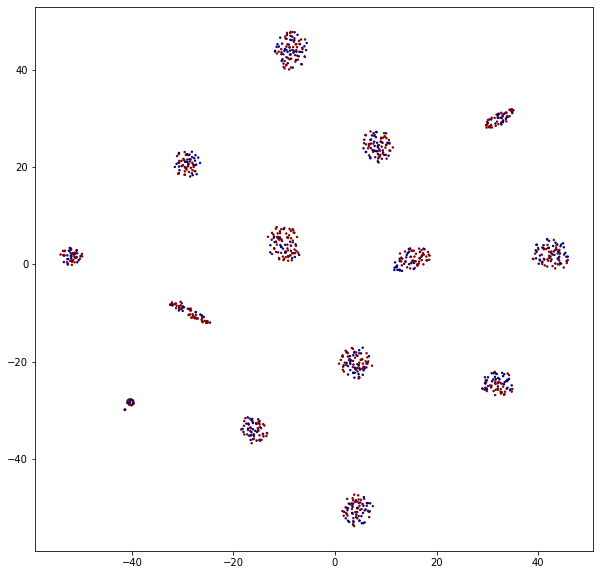

epoch: 2, manual: loss_g: 1.0037 loss_g_ae: 0.9906 loss_g_clas: 3.3414 loss_d: 0.0785 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9750 accu_g: 0.3400 accu_g_gdy: 0.3750 bleu: 53.2900 equal: 0.1830 spam: 0.0030 bleu_remain: 46.5662 acc_remain: 0.4511


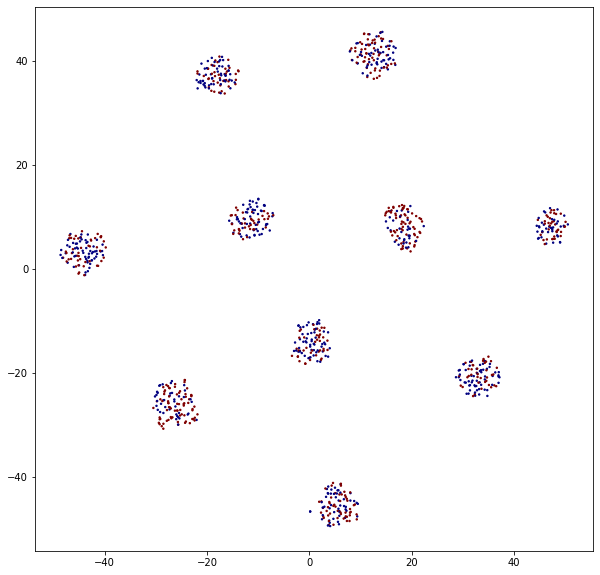

gamma: 1.0, lambda_g: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 3, step: 1, loss_d: 0.0224 accu_d: 1.0000
epoch: 3, step: 1, loss_g: 1.1065 loss_g_ae: 1.0450 loss_g_clas: 2.3742 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.4219 accu_g_gdy: 0.5312
epoch: 3, step: 500, loss_d: 0.0486 accu_d: 0.9828
epoch: 3, step: 500, loss_g: 0.4573 loss_g_ae: 0.4424 loss_g_clas: 4.1983 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.2969 accu_g_gdy: 0.2750
epoch: 3, step: 1000, loss_d: 0.0474 accu_d: 0.9859
epoch: 3, step: 1000, loss_g: 0.5477 loss_g_ae: 0.5231 loss_g_clas: 3.7455 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.3078 accu_g_gdy: 0.2562
epoch: 3, step: 1500, loss_d: 0.0628 accu_d: 0.9828
epoch: 3, step: 1500, loss_g: 0.3776 loss_g_ae: 0.3604 loss_g_clas: 4.8128 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.2281 accu_g_gdy: 0.2172
epoch: 3, step: 2000, loss_d: 0.0553 accu_d: 0.9875
epoch: 3, step: 2000, loss_g: 0.

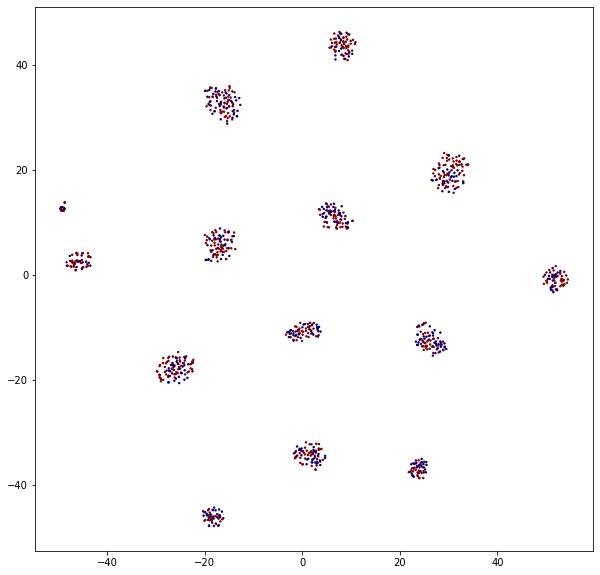

epoch: 3, manual: loss_g: 0.1170 loss_g_ae: 0.1161 loss_g_clas: 7.3434 loss_d: 0.0747 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9790 accu_g: 0.0660 accu_g_gdy: 0.0740 bleu: 90.9490 equal: 0.7110 spam: 0.0000 bleu_remain: 70.0802 acc_remain: 0.2040


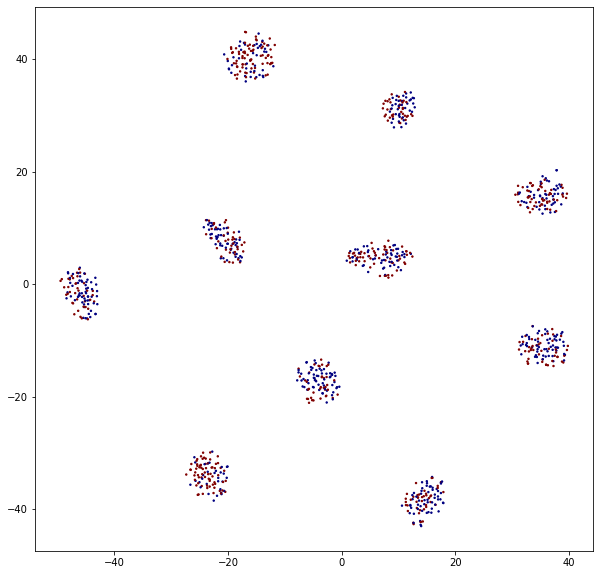

gamma: 1.0, lambda_g: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 4, step: 1, loss_d: 0.0253 accu_d: 1.0000
epoch: 4, step: 1, loss_g: 0.2052 loss_g_ae: 0.2005 loss_g_clas: 5.8256 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.1719 accu_g_gdy: 0.1562
epoch: 4, step: 1000, loss_d: 0.0211 accu_d: 0.9938
epoch: 4, step: 1000, loss_g: 0.1973 loss_g_ae: 0.1893 loss_g_clas: 6.7368 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.1047 accu_g_gdy: 0.1234
epoch: 4, step: 1500, loss_d: 0.0435 accu_d: 0.9859
epoch: 4, step: 1500, loss_g: 0.2168 loss_g_ae: 0.2036 loss_g_clas: 7.3333 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.1062 accu_g_gdy: 0.1016
epoch: 4, step: 2000, loss_d: 0.0397 accu_d: 0.9875
epoch: 4, step: 2000, loss_g: 0.1875 loss_g_ae: 0.1837 loss_g_clas: 7.1187 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.1016 accu_g_gdy: 0.0969
epoch: 4, step: 2500, loss_d: 0.0586 accu_d: 0.9781
epoch: 4, step: 2500, loss_g: 

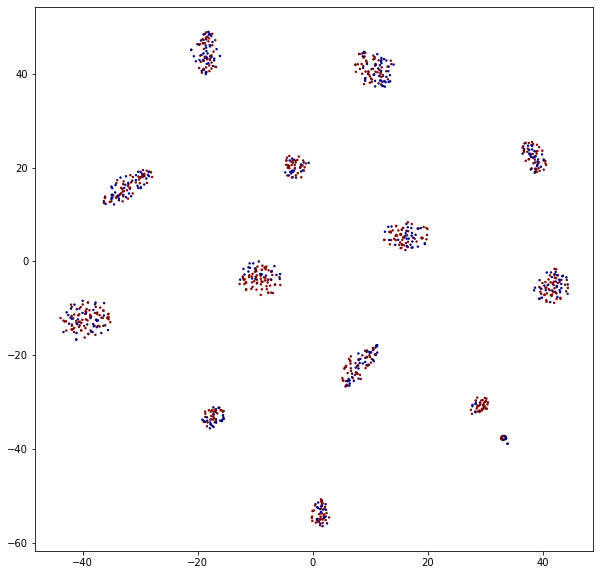

epoch: 4, test: loss_g: 0.0754 loss_g_ae: 0.0751 loss_g_clas: 8.3888 loss_d: 0.0712 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9763 accu_g: 0.0480 accu_g_gdy: 0.0507 bleu: 93.5542 equal: 0.8114 spam: 0.0007 bleu_remain: 71.1700 acc_remain: 0.1797


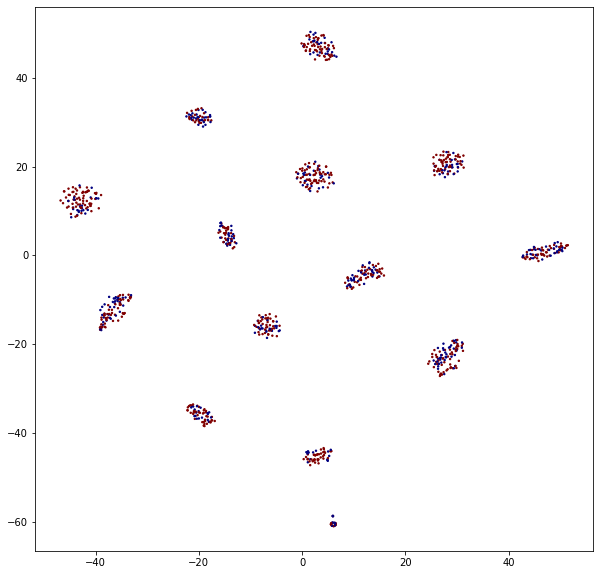

epoch: 4, manual: loss_g: 0.0718 loss_g_ae: 0.0713 loss_g_clas: 8.2964 loss_d: 0.0744 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9810 accu_g: 0.0470 accu_g_gdy: 0.0430 bleu: 94.6192 equal: 0.8120 spam: 0.0000 bleu_remain: 72.4782 acc_remain: 0.1468


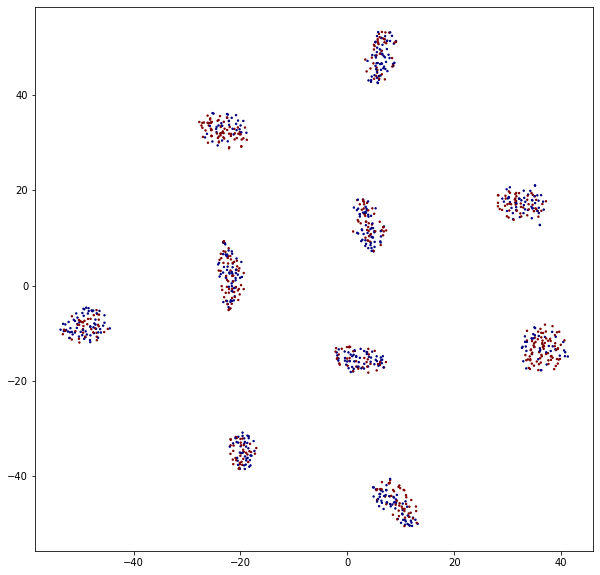

gamma: 1.0, lambda_g: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 5, step: 1, loss_d: 0.0205 accu_d: 1.0000
epoch: 5, step: 1, loss_g: 0.0991 loss_g_ae: 0.0969 loss_g_clas: 6.6704 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.1562 accu_g_gdy: 0.0781
epoch: 5, step: 500, loss_d: 0.0304 accu_d: 0.9922
epoch: 5, step: 500, loss_g: 0.1214 loss_g_ae: 0.1182 loss_g_clas: 8.0591 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0813 accu_g_gdy: 0.0875
epoch: 5, step: 1000, loss_d: 0.0172 accu_d: 0.9969
epoch: 5, step: 1000, loss_g: 0.1372 loss_g_ae: 0.1353 loss_g_clas: 8.4255 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0828 accu_g_gdy: 0.0797
epoch: 5, step: 1500, loss_d: 0.0561 accu_d: 0.9828
epoch: 5, step: 1500, loss_g: 0.1556 loss_g_ae: 0.1521 loss_g_clas: 8.8502 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0891 accu_g_gdy: 0.1016
epoch: 5, step: 2000, loss_d: 0.0602 accu_d: 0.9797
epoch: 5, step: 2000, loss_g: 0.

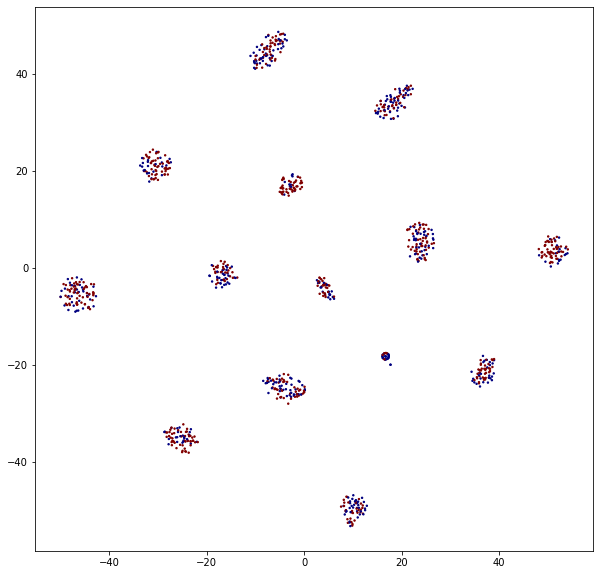

epoch: 5, test: loss_g: 0.0680 loss_g_ae: 0.0679 loss_g_clas: 9.2904 loss_d: 0.0747 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9760 accu_g: 0.0442 accu_g_gdy: 0.0474 bleu: 93.9499 equal: 0.8231 spam: 0.0012 bleu_remain: 71.6105 acc_remain: 0.1711


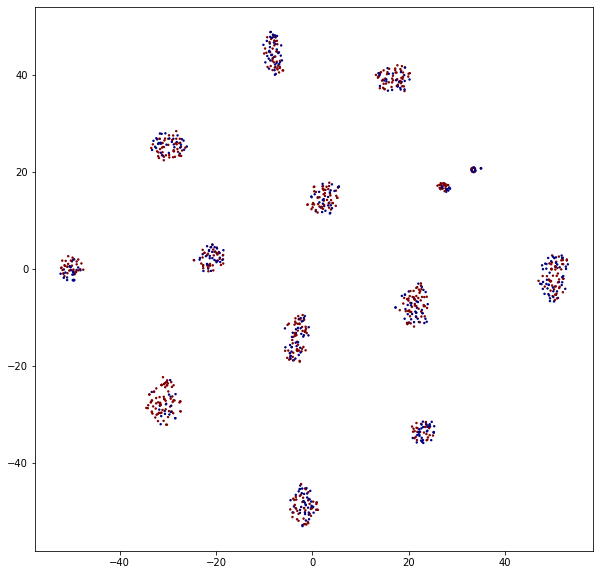

epoch: 5, manual: loss_g: 0.0669 loss_g_ae: 0.0665 loss_g_clas: 9.1501 loss_d: 0.0705 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9810 accu_g: 0.0450 accu_g_gdy: 0.0450 bleu: 94.9868 equal: 0.8300 spam: 0.0030 bleu_remain: 71.0287 acc_remain: 0.1669


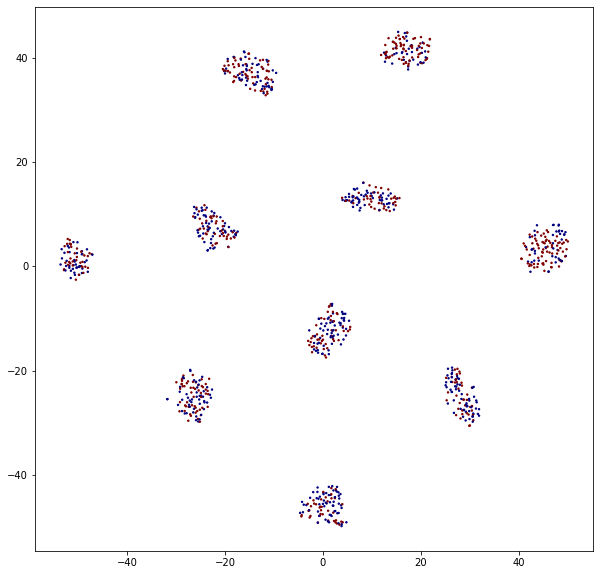

gamma: 1.0, lambda_g: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 6, step: 1, loss_d: 0.0090 accu_d: 1.0000
epoch: 6, step: 1, loss_g: 0.1174 loss_g_ae: 0.1152 loss_g_clas: 8.6602 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0469 accu_g_gdy: 0.0312
epoch: 6, step: 500, loss_d: 0.0167 accu_d: 0.9938
epoch: 6, step: 500, loss_g: 0.0932 loss_g_ae: 0.0919 loss_g_clas: 9.4364 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0563 accu_g_gdy: 0.0672
epoch: 6, step: 1000, loss_d: 0.0293 accu_d: 0.9875
epoch: 6, step: 1000, loss_g: 0.1135 loss_g_ae: 0.1122 loss_g_clas: 10.3985 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0578 accu_g_gdy: 0.0656
epoch: 6, step: 1500, loss_d: 0.0413 accu_d: 0.9859
epoch: 6, step: 1500, loss_g: 0.1239 loss_g_ae: 0.1220 loss_g_clas: 9.9356 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0766 accu_g_gdy: 0.0688
epoch: 6, step: 2000, loss_d: 0.0261 accu_d: 0.9922
epoch: 6, step: 2000, loss_g: 0

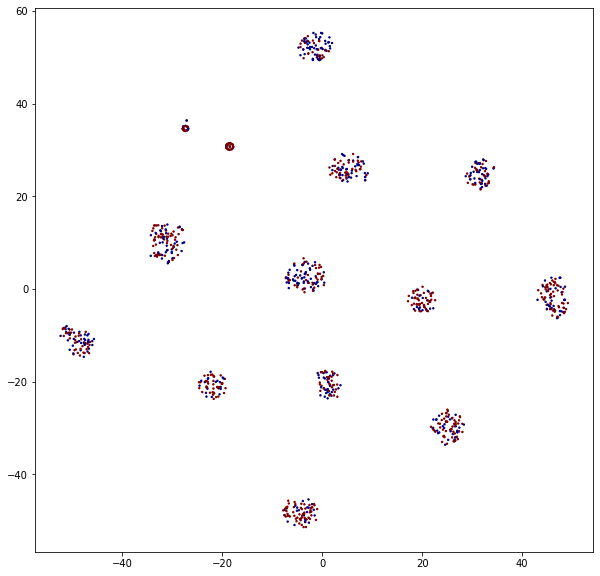

epoch: 6, test: loss_g: 0.0531 loss_g_ae: 0.0530 loss_g_clas: 10.8851 loss_d: 0.0824 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9755 accu_g: 0.0409 accu_g_gdy: 0.0433 bleu: 95.3928 equal: 0.8610 spam: 0.0004 bleu_remain: 72.0676 acc_remain: 0.1759


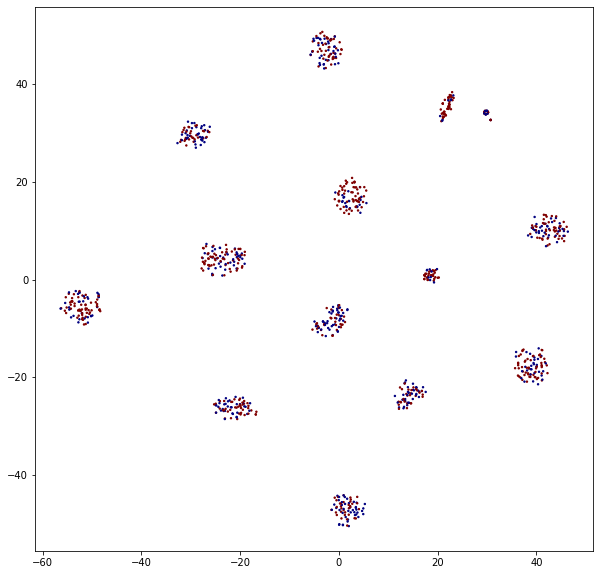

epoch: 6, manual: loss_g: 0.0611 loss_g_ae: 0.0608 loss_g_clas: 10.6717 loss_d: 0.0796 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9840 accu_g: 0.0450 accu_g_gdy: 0.0520 bleu: 95.6842 equal: 0.8540 spam: 0.0000 bleu_remain: 71.5195 acc_remain: 0.2826


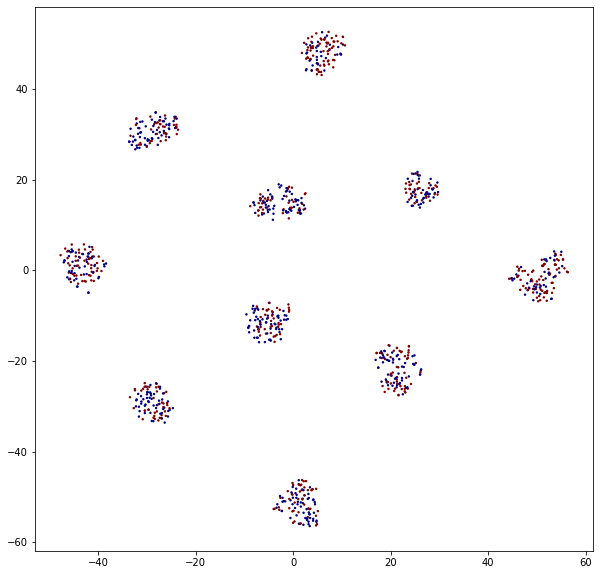

gamma: 1.0, lambda_g: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 7, step: 1, loss_d: 0.0404 accu_d: 0.9844
epoch: 7, step: 1, loss_g: 0.1037 loss_g_ae: 0.1024 loss_g_clas: 10.5568 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0312 accu_g_gdy: 0.0312
epoch: 7, step: 500, loss_d: 0.0177 accu_d: 0.9938
epoch: 7, step: 500, loss_g: 0.0868 loss_g_ae: 0.0849 loss_g_clas: 10.4285 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0437 accu_g_gdy: 0.0516
epoch: 7, step: 1000, loss_d: 0.0198 accu_d: 0.9906
epoch: 7, step: 1000, loss_g: 0.1080 loss_g_ae: 0.1059 loss_g_clas: 10.9416 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0484 accu_g_gdy: 0.0547
epoch: 7, step: 1500, loss_d: 0.0214 accu_d: 0.9891
epoch: 7, step: 1500, loss_g: 0.0909 loss_g_ae: 0.0900 loss_g_clas: 10.9630 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0516 accu_g_gdy: 0.0609
epoch: 7, step: 2000, loss_d: 0.0135 accu_d: 0.9922
epoch: 7, step: 2000, loss_g

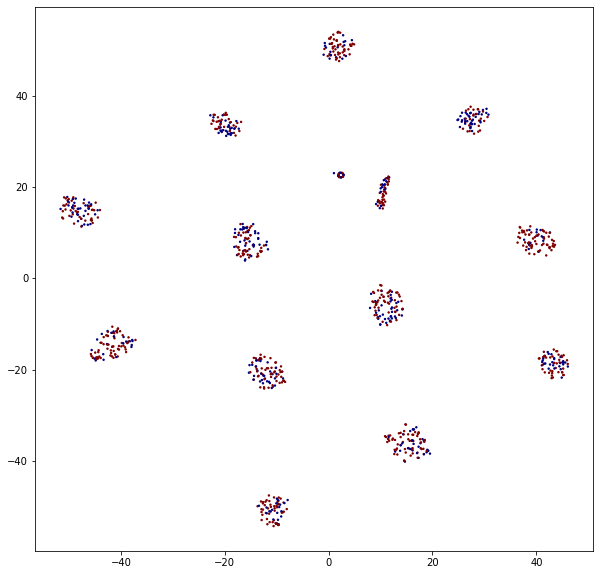

epoch: 7, test: loss_g: 0.0407 loss_g_ae: 0.0406 loss_g_clas: 11.4275 loss_d: 0.0859 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9753 accu_g: 0.0366 accu_g_gdy: 0.0384 bleu: 96.5988 equal: 0.8939 spam: 0.0004 bleu_remain: 73.1039 acc_remain: 0.1703


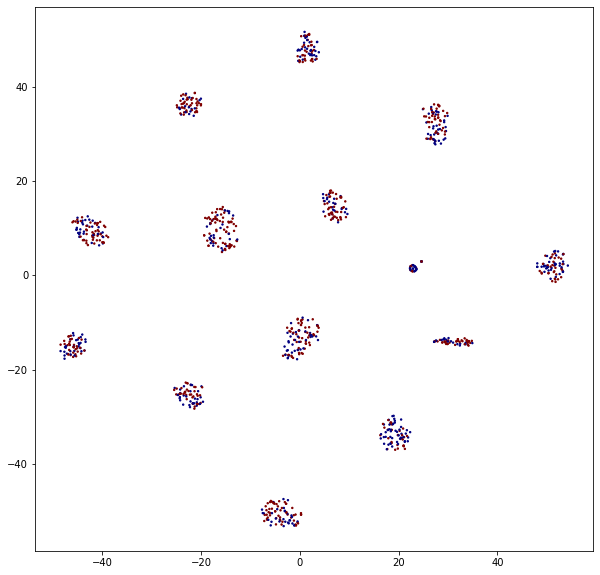

epoch: 7, manual: loss_g: 0.0454 loss_g_ae: 0.0444 loss_g_clas: 11.3139 loss_d: 0.0827 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9800 accu_g: 0.0370 accu_g_gdy: 0.0370 bleu: 96.9752 equal: 0.8870 spam: 0.0000 bleu_remain: 74.7488 acc_remain: 0.1553


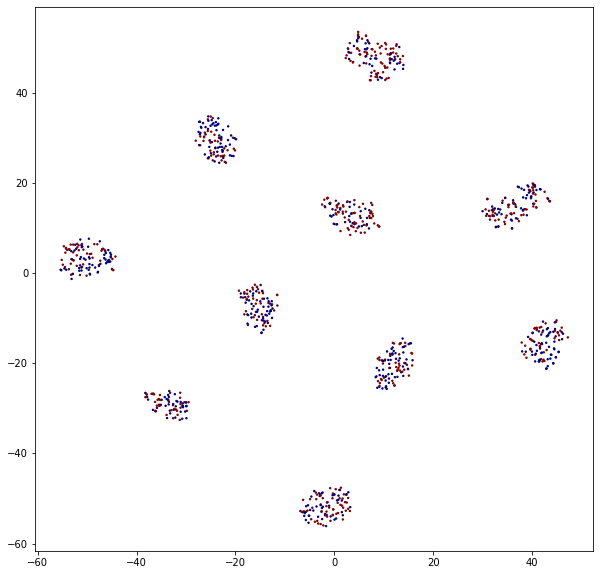

gamma: 1.0, lambda_g: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 8, step: 1, loss_d: 0.0495 accu_d: 0.9688
epoch: 8, step: 1, loss_g: 0.1008 loss_g_ae: 0.1000 loss_g_clas: 11.4515 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0000 accu_g_gdy: 0.0156
epoch: 8, step: 500, loss_d: 0.0235 accu_d: 0.9938
epoch: 8, step: 500, loss_g: 0.0892 loss_g_ae: 0.0882 loss_g_clas: 10.9751 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0453 accu_g_gdy: 0.0469
epoch: 8, step: 1000, loss_d: 0.0119 accu_d: 0.9953
epoch: 8, step: 1000, loss_g: 0.0826 loss_g_ae: 0.0816 loss_g_clas: 11.2088 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0422 accu_g_gdy: 0.0453
epoch: 8, step: 1500, loss_d: 0.0342 accu_d: 0.9922
epoch: 8, step: 1500, loss_g: 0.0886 loss_g_ae: 0.0860 loss_g_clas: 11.6679 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0453 accu_g_gdy: 0.0578
epoch: 8, step: 2000, loss_d: 0.0361 accu_d: 0.9875
epoch: 8, step: 2000, loss_g

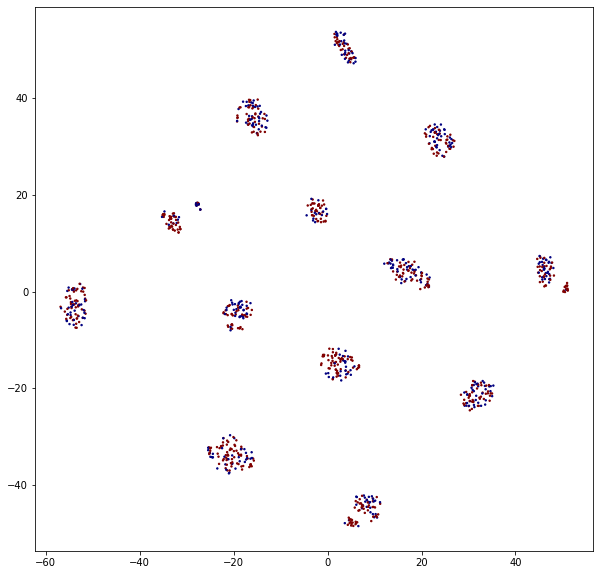

epoch: 8, test: loss_g: 0.0424 loss_g_ae: 0.0422 loss_g_clas: 12.1353 loss_d: 0.0914 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9749 accu_g: 0.0339 accu_g_gdy: 0.0361 bleu: 96.3563 equal: 0.8840 spam: 0.0003 bleu_remain: 77.2274 acc_remain: 0.1434


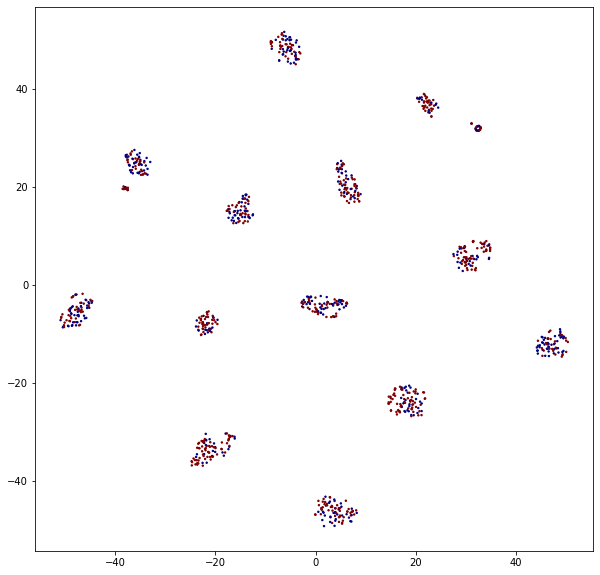

epoch: 8, manual: loss_g: 0.0432 loss_g_ae: 0.0429 loss_g_clas: 12.0654 loss_d: 0.0969 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9760 accu_g: 0.0360 accu_g_gdy: 0.0430 bleu: 96.6764 equal: 0.8730 spam: 0.0000 bleu_remain: 78.2956 acc_remain: 0.1574


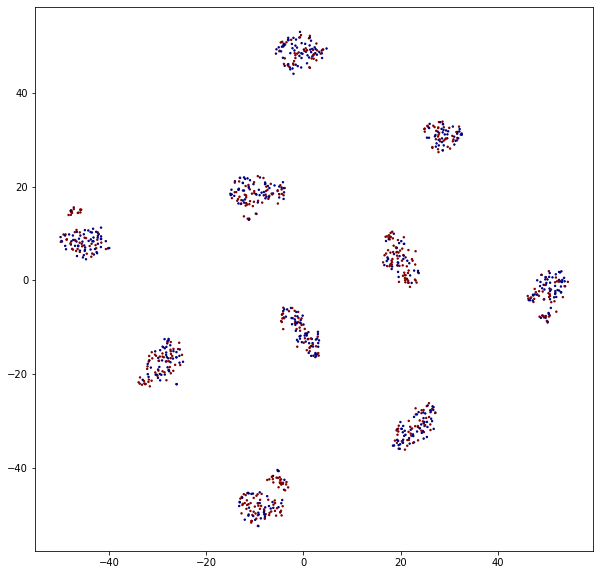

gamma: 1.0, lambda_g: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 9, step: 1, loss_d: 0.0167 accu_d: 1.0000
epoch: 9, step: 1, loss_g: 0.1599 loss_g_ae: 0.1567 loss_g_clas: 10.9617 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0312 accu_g_gdy: 0.0312
epoch: 9, step: 500, loss_d: 0.0407 accu_d: 0.9891
epoch: 9, step: 500, loss_g: 0.1022 loss_g_ae: 0.0997 loss_g_clas: 13.2838 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0359 accu_g_gdy: 0.0547
epoch: 9, step: 1000, loss_d: 0.0349 accu_d: 0.9875
epoch: 9, step: 1000, loss_g: 0.1143 loss_g_ae: 0.1053 loss_g_clas: 13.0150 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0375 accu_g_gdy: 0.0359
epoch: 9, step: 1500, loss_d: 0.0098 accu_d: 0.9969
epoch: 9, step: 1500, loss_g: 0.1086 loss_g_ae: 0.1040 loss_g_clas: 12.6984 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0484 accu_g_gdy: 0.0453
epoch: 9, step: 2000, loss_d: 0.0188 accu_d: 0.9922
epoch: 9, step: 2000, loss_g

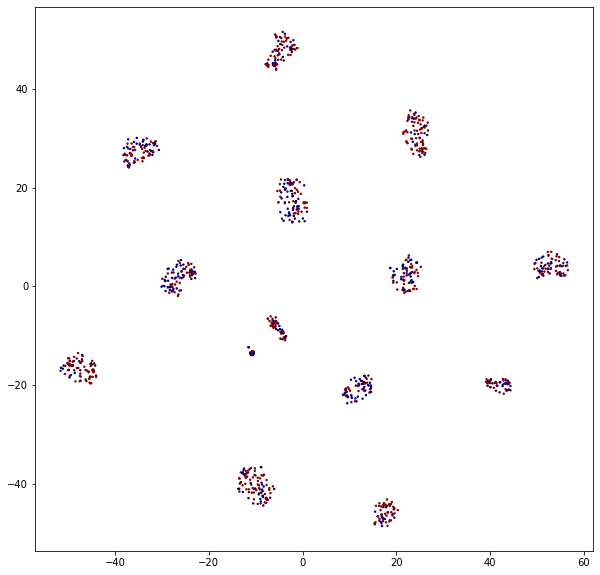

epoch: 9, manual: loss_g: 0.0289 loss_g_ae: 0.0288 loss_g_clas: 13.1322 loss_d: 0.1007 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9760 accu_g: 0.0330 accu_g_gdy: 0.0320 bleu: 98.1980 equal: 0.9350 spam: 0.0000 bleu_remain: 68.6313 acc_remain: 0.1478


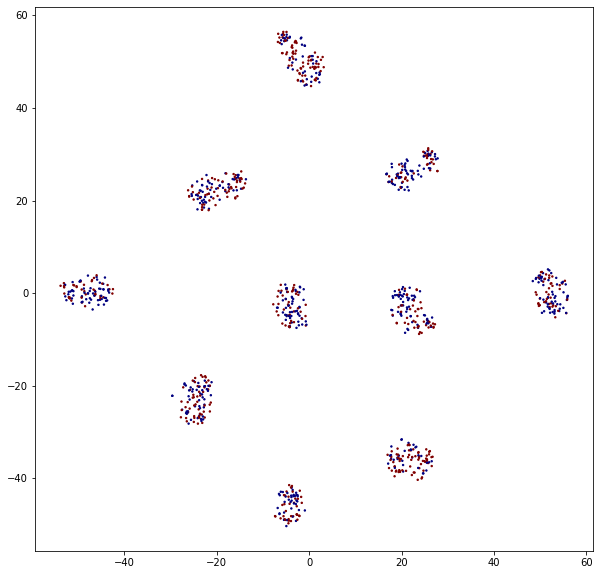

gamma: 1.0, lambda_g: 0.0, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 10, step: 1, loss_d: 0.0120 accu_d: 1.0000
epoch: 10, step: 1, loss_g: 0.1239 loss_g_ae: 0.1228 loss_g_clas: 12.6278 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0312 accu_g_gdy: 0.0312
epoch: 10, step: 500, loss_d: 0.0196 accu_d: 0.9953
epoch: 10, step: 500, loss_g: 0.0852 loss_g_ae: 0.0835 loss_g_clas: 13.7488 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0125 accu_g_gdy: 0.0203
epoch: 10, step: 1000, loss_d: 0.0237 accu_d: 0.9922
epoch: 10, step: 1000, loss_g: 0.0710 loss_g_ae: 0.0695 loss_g_clas: 13.8901 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0359 accu_g_gdy: 0.0437
epoch: 10, step: 1500, loss_d: 0.0079 accu_d: 0.9969
epoch: 10, step: 1500, loss_g: 0.0904 loss_g_ae: 0.0878 loss_g_clas: 13.5445 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0344 accu_g_gdy: 0.0344
epoch: 10, step: 2000, loss_d: 0.0232 accu_d: 0.9953
epoch: 10, step: 20

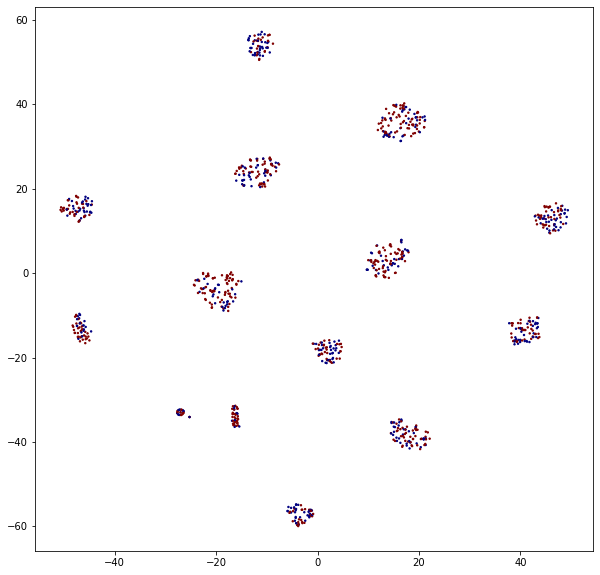

epoch: 10, test: loss_g: 0.0209 loss_g_ae: 0.0207 loss_g_clas: 13.0815 loss_d: 0.1038 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9730 accu_g: 0.0314 accu_g_gdy: 0.0327 bleu: 98.3420 equal: 0.9467 spam: 0.0002 bleu_remain: 71.3228 acc_remain: 0.1522


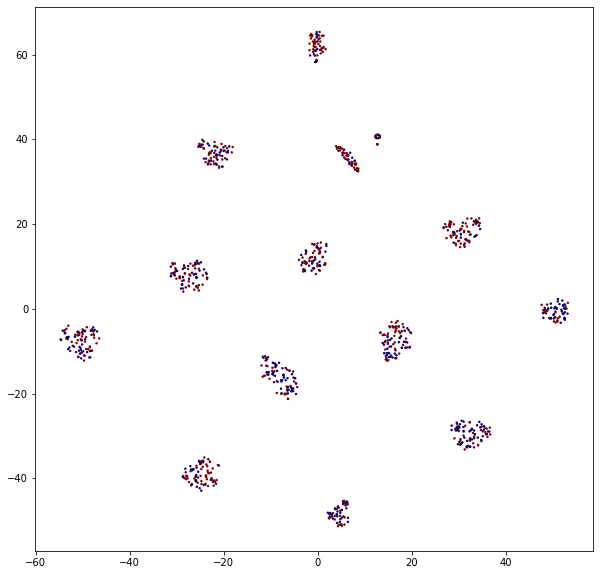

epoch: 10, manual: loss_g: 0.0209 loss_g_ae: 0.0207 loss_g_clas: 13.3638 loss_d: 0.1002 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9690 accu_g: 0.0380 accu_g_gdy: 0.0390 bleu: 98.6559 equal: 0.9490 spam: 0.0000 bleu_remain: 69.4022 acc_remain: 0.1472


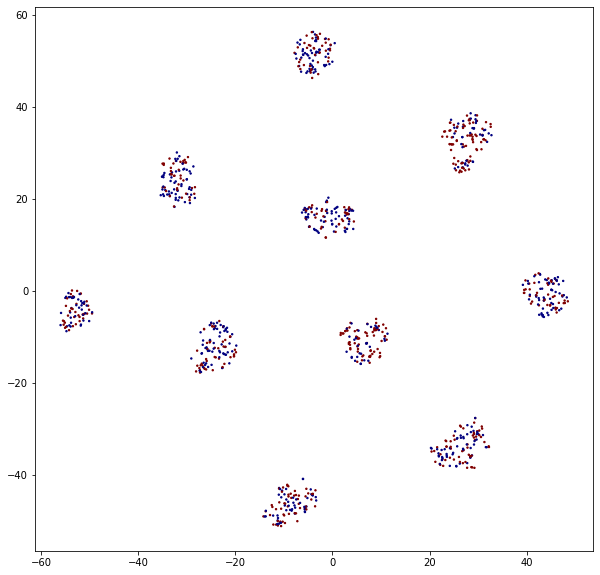

gamma: 0.5, lambda_g: 0.1, lambda_z1: 3000.0, lambda_z2: 3000.0, lambda_ae: 1.0
epoch: 11, step: 1, loss_d: 0.0301 accu_d: 0.9844
epoch: 11, step: 1, loss_g: 1.4788 loss_g_ae: 0.1132 loss_g_clas: 13.6466 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.0469 accu_g_gdy: 0.0312
epoch: 11, step: 500, loss_d: 0.0296 accu_d: 0.9938
epoch: 11, step: 500, loss_g: 0.5806 loss_g_ae: 0.3769 loss_g_clas: 2.0043 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.7188 accu_g_gdy: 0.7156
epoch: 11, step: 1000, loss_d: 0.0197 accu_d: 0.9922
epoch: 11, step: 1000, loss_g: 0.4934 loss_g_ae: 0.3150 loss_g_clas: 1.7526 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.7531 accu_g_gdy: 0.7500
epoch: 11, step: 1500, loss_d: 0.0130 accu_d: 0.9938
epoch: 11, step: 1500, loss_g: 0.4860 loss_g_ae: 0.3203 loss_g_clas: 1.6262 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.7734 accu_g_gdy: 0.7578
epoch: 11, step: 2000, loss_d: 0.0334 accu_d: 0.9891
epoch: 11, step: 2000,

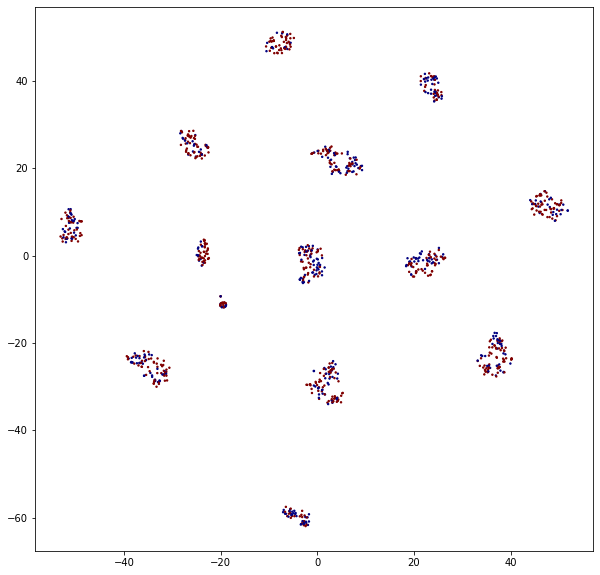

epoch: 12, step: 1000, loss_d: 0.0227 accu_d: 0.9953
epoch: 12, step: 1000, loss_g: 0.4204 loss_g_ae: 0.2602 loss_g_clas: 1.5510 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.7875 accu_g_gdy: 0.8094
epoch: 12, step: 1500, loss_d: 0.0144 accu_d: 0.9969
epoch: 12, step: 1500, loss_g: 0.3802 loss_g_ae: 0.2183 loss_g_clas: 1.5834 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.7937 accu_g_gdy: 0.7937
epoch: 12, step: 2000, loss_d: 0.0111 accu_d: 0.9953
epoch: 12, step: 2000, loss_g: 0.3807 loss_g_ae: 0.2724 loss_g_clas: 1.0031 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.8516 accu_g_gdy: 0.8344
epoch: 12, step: 3000, loss_d: 0.0187 accu_d: 0.9906
epoch: 12, step: 3000, loss_g: 0.4122 loss_g_ae: 0.2498 loss_g_clas: 1.5845 loss_shifted_ae1: 0.0000 loss_shifted_ae2: 0.0000 accu_g: 0.8031 accu_g_gdy: 0.8031
epoch: 12, step: 3500, loss_d: 0.0221 accu_d: 0.9953
epoch: 12, step: 3500, loss_g: 0.4354 loss_g_ae: 0.2975 loss_g_clas: 1.3202 loss_shifted_ae1: 0

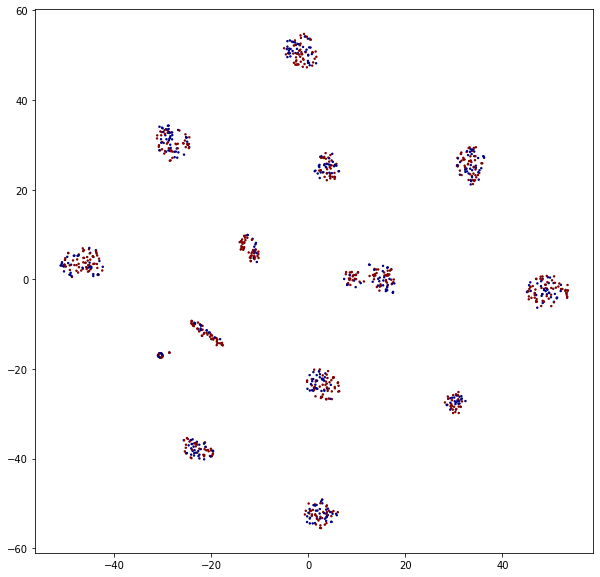

epoch: 12, test: loss_g: 0.2601 loss_g_ae: 0.1318 loss_g_clas: 1.2753 loss_d: 0.1211 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9715 accu_g: 0.8238 accu_g_gdy: 0.8236 bleu: 66.0398 equal: 0.1234 spam: 0.0002 bleu_remain: 60.3641 acc_remain: 0.9207


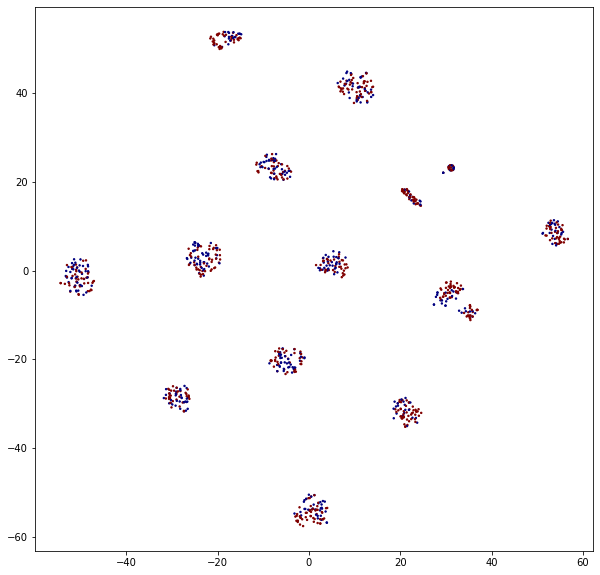

epoch: 12, manual: loss_g: 0.3261 loss_g_ae: 0.1732 loss_g_clas: 1.5261 loss_d: 0.1102 loss_cos_: 0.0000 loss_cos: 0.0000 accu_d: 0.9690 accu_g: 0.7850 accu_g_gdy: 0.7800 bleu: 69.1203 equal: 0.1470 spam: 0.0000 bleu_remain: 62.8744 acc_remain: 0.8946


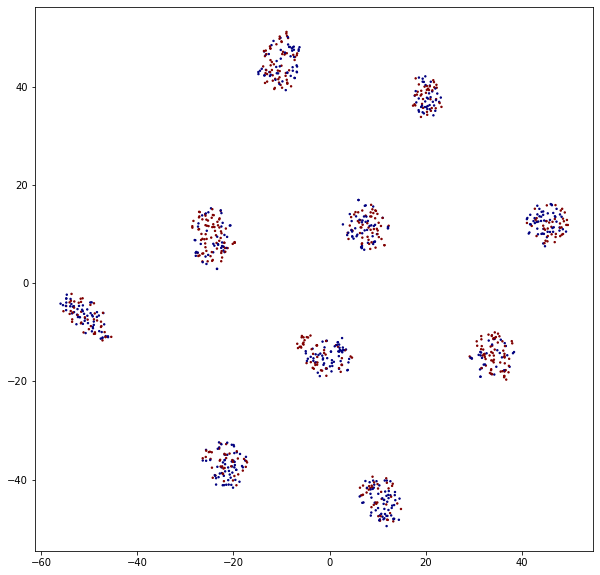

In [7]:
train_model()

In [12]:
print_result()

[['Input Sentence', 'Input Label', 'Generated Sentence', 'Predicted Label', 'BLEU'], ['they were almost certainly _num_ % soda water with a lime .', 0, 'they were almost certainly wedding pleasant soda water with a lime .', 1, 0.6340466277046861], ['they called back later and told me no refund tough luck .', 0, 'they called back later and fave me sets respect impeccable luck .', 1, 0.37700638045494705], ['absolutely loved this restaurant .', 1, 'absolutely zero this restaurant .', 0, 0.7987822049880149], ['finally found an auto repair shop i can trust .', 1, 'finally found an auto repair shop i can trust .', 1, 1.0], ['atmosphere was fine & the service was excellent .', 1, 'atmosphere was fine & the service was worse .', 0, 0.7506238537503395], ['we will continue to be fans of <UNK> .', 1, 'we will needless to be fans of <UNK> .', 1, 0.6606328636027614], ['very good and many people call in for take out .', 1, 'very lazy and many people call in for take out .', 0, 0.8070557274927981], [

In [13]:
print_bleu()

BLEU: 0.4264
